# Brain Decoding Tutorial
Mohamed Abdelhack

In order to understand the way the brain encodes sensory information, we need to find a relation between the stimulus and the measured brain response. The brain is always active as it handles a plethora of information related to different functions both internal and external.

In this tutorial, we will deal with data measured during visual stimulation experiments and investigate areas in the brain that respond to these visual images.

In [ ]:
# @markdown [Prep] Run this cell to load data and install libraries
# data download and library installation
# Generic object decoding data
!wget -q -O data.h5 https://ndownloader.figshare.com/files/15049646
# Generic object decoding features
!wget -q -O features.h5 https://ndownloader.figshare.com/files/15015971
# Download ImageNet labels
!wget -q -O imagenet_classes.txt https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

!pip install -q bdpy
!pip install -q seaborn_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 13.3 MB/s eta 0:00:00


In [ ]:
# @markdown Include required libraries
import bdpy
from bdpy.util import get_refdata
import numpy as np
import pandas as pd
import seaborn_image as isns
import seaborn as sns
import ipywidgets as widgets  # interactive display
import matplotlib.pyplot as plt
from random import seed
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
import urllib
from PIL import Image
from torchvision import transforms
import torch

In [ ]:
rois = {'VC' : 'ROI_VC = 1',
        'LVC' : 'ROI_LVC = 1',
        'HVC' : 'ROI_HVC = 1',
        'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1'}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_id)
    seed(worker_id)

## Part 1: Classification Models

### Generalized Linear Models (GLM)


#### Linear Regression

(-4.027687906913337, 3.517570042376957, -5.6940523728166985, 5.178557274451938)

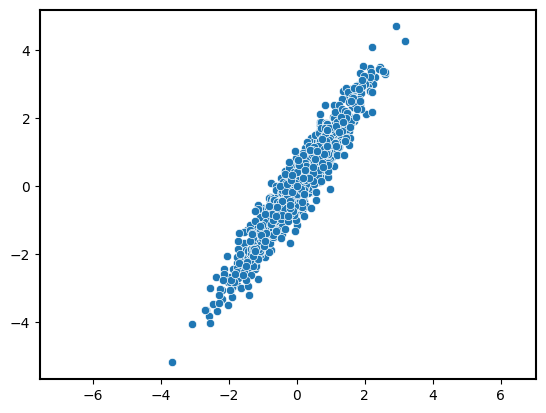

In [ ]:
# Simulate linear dependency

# Generate 1000 points randomly
x1 = np.random.normal(size=1000)
noise = np.random.normal(scale=0.3, size=1000)
y1 = 1.5 * x1
x1 = x1 + noise
sns.scatterplot(x=x1, y=y1)
plt.axis('equal')

In [ ]:
my_layout = widgets.Layout()

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    slope=widgets.FloatSlider(0., min=-3., max=3., step=.1,
                               layout=my_layout),
    offset=widgets.FloatSlider(0., min=-3., max=3., step=0.2,
                                layout=my_layout)
)

def diff_DC(slope=200., offset=10.):
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
  sns.scatterplot(x=x1, y=y1, ax=axes[0])
  x_data = np.array([-3, 3])

  y_data = x_data * slope + offset
  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-3, 3)

  error = np.square(y1 - (x1 * slope + offset))
  axes[1].stem(x1, error, use_line_collection=True)
  axes[1].set_ylim(0, 5)
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='slope', layout=Layout(width='450px'), max=3.0, min=-…

#### Logistic Regression

In [ ]:
# Logistic regression
x1 = np.random.normal(size=1000)
# noise = np.random.normal(scale=0.3, size=1000)
y1 = 1.5 * x1
y1_binary = (y1 > 0.0).astype(float)

my_layout = widgets.Layout()

def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    slope=widgets.FloatSlider(1., min=0., max=10., step=.1,
                               layout=my_layout),
    offset=widgets.FloatSlider(0., min=-3., max=3., step=0.2,
                                layout=my_layout)
)



def diff_DC(slope=0., offset=0.):
  fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))
  sns.scatterplot(x=x1, y=y1_binary, ax=axes[0])
  x_data = np.linspace(-3, 3, 1000)

  y_data = 1 / (1 + np.exp(-(x_data * slope + offset)))

  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-0.1, 1.1)

  error = BinaryCrossEntropy(y1_binary, 1 / (1 + np.exp(-(x1 * slope + offset))))
  sns.barplot(x=[0], y=[error], ax=axes[1])
  axes[1].set_ylim(-0.1, 1.1)
  plt.show()


interactive(children=(FloatSlider(value=1.0, description='slope', layout=Layout(width='450px'), max=10.0), Flo…

By moving the sliders, you are modifying the parameters of the linear regression model to produce the model that most likely has generated the data. This case of one input and one output is trivial but usually you will get multiple input variables for the output with some of the inputs related to the output to different degrees and some not related at all. The question here is how to tune your model to have the correct attributions between inputs and outputs and how to automate the process. One way to do that is to find the error between the real output features and the predicted output features of the model and try to minimize that. This loss is called mean squared error loss and is used predominantly in linear regression:

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( y_i - \hat{y}_i \right)^2$$


While for logistic regression, binary cross entropy function is used instead:


$$\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$


Minimizing the loss function can be achieved by multiple ways such as gradient descent. This is readily implemented in scikit learn for you as follows.

In [ ]:
linear_model = LinearRegression()
linear_model.fit(np.expand_dims(x1, axis=1), y1)
print(linear_model.coef_)

[1.5]


You can see the predicted weight is very close to the real one. At the end of the notebook, there is an exercise if you are interested in how this actually works on the inside.

Now let’s consider a case of fewer points and three inputs. You can now tune four parameters. In this condition, we want to test the quality of our model so we hide some points (test set) and you should tune the parameters on the visible points only (training set). First, imaging that the output is only dependent on x1 and observe the model.

In [ ]:
seed_worker(0)

x1 = np.random.normal(size=10)
noise1 = np.random.normal(scale=1, size=10)
x2 = np.random.normal(size=10)
noise2 = np.random.normal(scale=1, size=10)
x3 = np.random.normal(size=10, scale=1)
noise3 = np.random.normal(scale=1, size=10)
y1 = 0.9 * x1 + 0.4 * x2
x1 = x1 + noise1
x2 = x2 + noise2
x3 = x3 + noise3

In [ ]:
my_layout = widgets.Layout()

# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    beta0=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta1=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta2=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                               layout=my_layout),
    beta3=widgets.FloatSlider(0., min=-4., max=4., step=.1,
                                layout=my_layout),
    proportion_train=widgets.FloatSlider(0.3, min=0., max=100., step=10.,
                                layout=my_layout),
    flag_m=widgets.Checkbox(value=False, description='show_test', disabled=False, indent=False)
)

def diff_DC(beta0=0., beta1=0., beta2=0.,
            beta3=0., proportion_train=0.5, flag_m=False):
  fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
  number_of_train_points = int(proportion_train * x1.shape[0])
  sns.scatterplot(x=x1[:number_of_train_points],
                  y=y1[:number_of_train_points],
                  ax=axes[0], color='r')
  if flag_m:
    sns.scatterplot(x=x1[number_of_train_points:],
                  y=y1[number_of_train_points:],
                  ax=axes[0], color='g')
  x_data = x1

  y_data = x1 * beta1 + x2 * beta2 + x3 * beta3 + beta0
  sns.lineplot(x=x_data, y=y_data, ax=axes[0], color='k')
  axes[0].axis('equal')
  axes[0].set_xlim(-3, 3)
  axes[0].set_ylim(-3, 3)

  error = np.abs(y1 - y_data)
  axes[1].stem(x1[:number_of_train_points], error[:number_of_train_points], linefmt='red', markerfmt='ro', use_line_collection=True)
  if flag_m:
    axes[1].stem(x1[number_of_train_points:], error[number_of_train_points:], linefmt='green', markerfmt='go', use_line_collection=True)
  axes[1].set_ylim(0, 5)
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='beta0', layout=Layout(width='450px'), max=4.0, min=-…

In [ ]:
# Prepare training and test sets
X = np.vstack((x1, x2, x3)).T
X_train = X[:3, :]
X_test = X[3:, :]
y_train = y1[:3]
y_test = y1[3:]

# Try these parameters in the widget
print(np.linalg.inv(X_train).dot(y1[:3]))

[-0.14301916  0.19111806 -0.66751113]


Discuss: how optimal is this model? What is the source of error?

Now let’s consider the case that all the inputs have an association with the model and try to minimize the error in the training set.
Discuss: how optimal is this model? What is the source of error?


Now try to re-implement the same optimization in scikit-learn?

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print(linear_model.coef_)

[-0.10807557  0.19301173 -0.67258269]


Which model did you get?

What is your observation of the weight values in comparison to the true weights?

Can you propose a way to prevent the model from doing this?


You can notice that overfitting is the more common output and it is mainly associated with larger than reasonable weights overall. Introducing a penalty on the values of the weights can decrease the possibility of having large weights. This can be achieved by either L1 or L2 regularization. Let’s implement one of them in the loss function.

L1 loss function:

$$
\text{Loss} = \text{Error}(y, \hat{y}) + \lambda \sum_{i=1}^{N} \left| w_i \right|
$$


L2 loss function:

$$
\text{Loss} = \text{Error}(y, \hat{y}) + \lambda \sum_{i=1}^{N} w_i^2
$$


Where λ controls the amount of regularization.

In [ ]:
linear_model = Ridge()
linear_model.fit(X_train, y_train)
print(linear_model.coef_)

[-0.03698999  0.08952323 -0.22143761]


What do you observe?

##### Logistic Regression using sklearn

In [ ]:
from sklearn.linear_model import LogisticRegression
x1 = np.random.normal(size=1000)
y1 = 1.5 * x1 + np.random.normal(scale=0.5, size=1000)
y1_binary = (y1 > 0.0).astype(float)
x1 = np.expand_dims(x1, 1)
linear_model = LogisticRegression()
linear_model.fit(x1, y1_binary.squeeze())

LogisticRegression()

### Explore data
Now let’s look at real brain data. We will be using data from the paper (horikawa et al paper). The dataset contains a large amount of fMRI data of images shown to subjects. Some of those images are repeatedly shown to the subject while others are shown once but different images having the same main objects (note: those images are not necessarily the ones in the dataset):

Similar: Gold fish category

<img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/>

Different: Cat category

<img src="https://drive.google.com/uc?id=1vSehKdq7Tl_gsUxc4xLOuSXYxF-VjJkd" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1FhEotidDDc9jnR-tWX4EMUXqZr0Avam4" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1hnbpYWpkymEOi_FWb5XxLq2pG4j53TAc" alt="drawing" height="100"/>

We will look at the data from one of the subjects (there is actually more in this dataset some of which will be explained later in part 2 and some we won’t use but can be part of your project 😉). We will be using the Brain Decoding Toolbox library for loading the data since it makes dealing with the data very easy (Also the dataset is available to be loaded directly into this format).

In [ ]:
np.random.seed(0)

In [ ]:
# Get data of images from the GOD dataset
filename = 'data.h5'
voxel_data = bdpy.BData(filename)
voxel_data.show_metadata()

| Key            | Description                                                                       |
|----------------|-----------------------------------------------------------------------------------|
| DataType       | 1 = Data type (1 = Training data; 2 = Perception test data; 3 = Imagery test data |
| Run            | 1 = Run number                                                                    |
| Label          | 1 = Label (image ID)                                                              |
| VoxelData      | 1 = Voxel data                                                                    |
| voxel_x        | Voxel x coordinate                                                                |
| voxel_y        | Voxel y coordinate                                                                |
| voxel_z        | Voxel z coordinate                                                                |
| VolInds        | 1 = Volume index                                      

You now have brain data from different regions in the visual cortex corresponding to subjects watching visual stimuli. Can you build a classifier to know which image the subject is watching? We made the following function to help you extract data belonging to two different images so you can build a binary classifier.

In [ ]:
# data extraction functions
def extract_data(roi, image_type='similar', number_of_categories=2):
  filename = 'data.h5'
  data = bdpy.BData(filename)
  voxel_data = data.select(rois[roi])
  data_type = data.select('DataType')
  data_labels = data.select('stimulus_id')
  if image_type == 'similar':
    data_filter = (data_type == 2).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'different':
    data_filter = (data_type == 1).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'imagery':
    data_filter = (data_type == 3).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  # print('data labels before floor/int', data_labels)

  data_labels = np.floor(data_labels).astype(int)
  # print('data labels after floor/int', data_labels)

  unique_data_labels = np.unique(data_labels)
  unique_data_labels_filtered = unique_data_labels[:number_of_categories]
  # Works only with binary classification, not generalized!!!
  data_label_filter = [True if label in list(unique_data_labels_filtered) else False for label in data_labels]

  voxel_data = voxel_data[data_label_filter, :]
  data_labels = data_labels[data_label_filter, :]


  return voxel_data, data_labels


In [ ]:
X, y = extract_data('LOC', image_type='similar')
print(X.shape)
print(y.shape)

(70, 540)
(70, 1)


In [ ]:
y

array([[1443537],
       [1621127],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [1443537],
       [1621127],
       [1443537],
       [1621127],
       [1443537],
       [16

### Multivariate Pattern Analysis (MVPA)

Now that you have seen how the data is structured, attempt to build a classifier and check its accuracy

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score



#### Single ROI, using Linear and Logistic Regression

In [ ]:
# Using Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
linear_model_no_reg = LinearRegression()
linear_model_l1 = Lasso(alpha=0.1, random_state = 7)  # L1 penalty
linear_model_l2 = Ridge(alpha=0.1, random_state = 7)  # L2 penalty

def evaluate_model(model, X, y):
    # For regression tasks, use 'r2' or 'neg_mean_squared_error' instead of 'accuracy'
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)
    print(f"{model.__class__.__name__} Cross-Validation R2 Score: {mean_cv_score:.2f}")
    return mean_cv_score

cv_scores_no_reg = evaluate_model(linear_model_no_reg, X_train, y_train)
cv_scores_l1 = evaluate_model(linear_model_l1, X_train, y_train)
cv_scores_l2 = evaluate_model(linear_model_l2, X_train, y_train)

LinearRegression Cross-Validation R2 Score: -0.18
Lasso Cross-Validation R2 Score: -0.20
Ridge Cross-Validation R2 Score: -0.18


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Assuming X and y are defined earlier in your code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

linear_model_no_reg = LinearRegression()
linear_model_l1 = Lasso(alpha=0.1)  # L1 penalty
linear_model_l2 = Ridge(alpha=0.1)  # L2 penalty

def regression_accuracy(y_true, y_pred, threshold=0.1):
    """
    Calculate an accuracy-like metric for regression.
    Predictions within threshold*std of the true value are considered "accurate".
    """
    std = np.std(y_true)
    return np.mean(np.abs(y_true - y_pred) <= threshold * std)

def evaluate_model(model, X, y, cv=5):
    def custom_scorer(estimator, X, y):
        y_pred = estimator.predict(X)
        return regression_accuracy(y, y_pred)

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=custom_scorer)
    mean_cv_score = np.mean(cv_scores)
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {mean_cv_score:.2f}")
    return mean_cv_score

cv_scores_no_reg = evaluate_model(linear_model_no_reg, X_train, y_train)
cv_scores_l1 = evaluate_model(linear_model_l1, X_train, y_train)
cv_scores_l2 = evaluate_model(linear_model_l2, X_train, y_train)

def evaluate_on_test_set(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = regression_accuracy(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} Test Set:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Mean Squared Error: {mse:.4f}")

evaluate_on_test_set(linear_model_no_reg, X_train, y_train, X_test, y_test)
evaluate_on_test_set(linear_model_l1, X_train, y_train, X_test, y_test)
evaluate_on_test_set(linear_model_l2, X_train, y_train, X_test, y_test)

LinearRegression Cross-Validation Accuracy: 0.12
Lasso Cross-Validation Accuracy: 0.05
Ridge Cross-Validation Accuracy: 0.08
LinearRegression Test Set:
  Accuracy: 0.00
  Mean Squared Error: 7738475954.3645
Lasso Test Set:
  Accuracy: 0.04
  Mean Squared Error: 9753910413.4943
Ridge Test Set:
  Accuracy: 0.00
  Mean Squared Error: 7759449923.8717


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
rndm_state = 7
# L2 Regularization
model_l2 = LogisticRegression(penalty='l2', random_state=rndm_state)
model_l2.fit(X_train, y_train)
acc_l2 = model_l2.score(X_test, y_test)

# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=rndm_state)
model_l1.fit(X_train, y_train)
acc_l1 = model_l1.score(X_test, y_test)

# No Regularization
model_none = LogisticRegression(penalty='none', random_state=rndm_state)
model_none.fit(X_train, y_train)
acc_none = model_none.score(X_test, y_test)

# Print accuracies
print(f"L2 Regularization Accuracy: {acc_l2}")
print(f"L1 Regularization Accuracy: {acc_l1}")
print(f"No Regularization Accuracy: {acc_none}")


L2 Regularization Accuracy: 0.5714285714285714
L1 Regularization Accuracy: 0.5238095238095238
No Regularization Accuracy: 0.5238095238095238


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

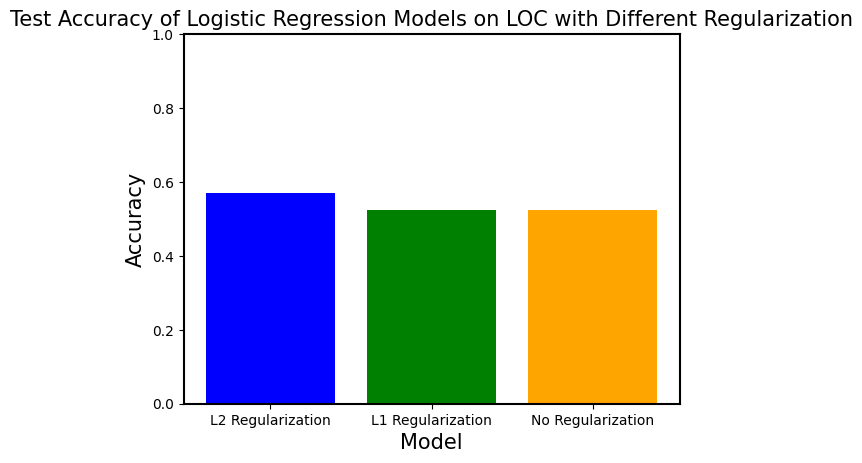

In [ ]:
import matplotlib.pyplot as plt

# Accuracies
accuracies = [acc_l2, acc_l1, acc_none]
labels = ['L2 Regularization', 'L1 Regularization', 'No Regularization']

# Creating the bar chart
plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Logistic Regression Models on LOC with Different Regularization')
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.show()


### Single ROI, Using SVM

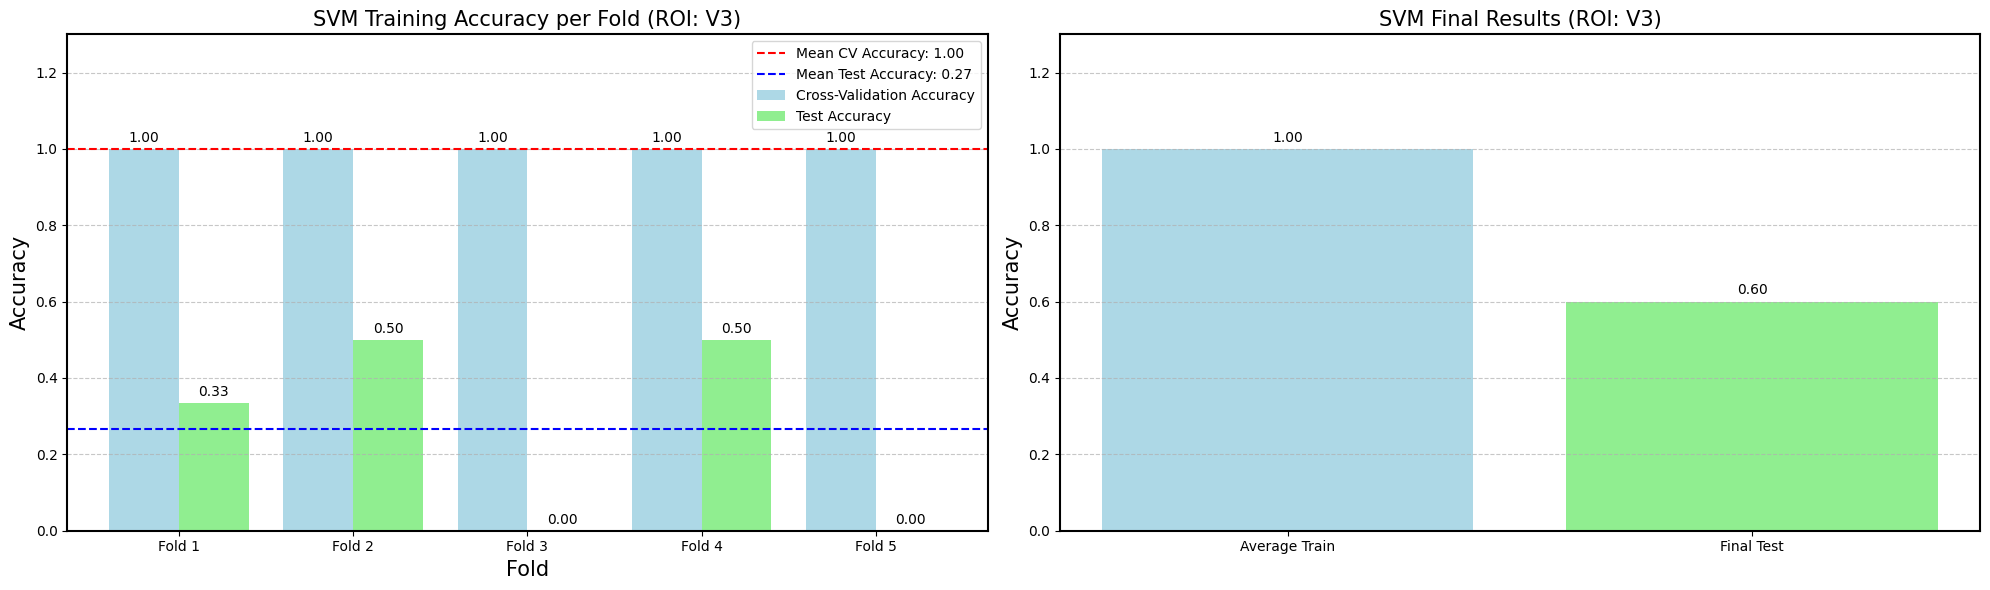

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# ROI of interest
roi = 'V3'

# Extract data
X, y = extract_data(roi, image_type='different')
y = y.ravel()  # Flatten y to be a 1D array

# Split the data into training and final test sets
X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.3, random_state=rndm_state)

# Initialize SVM model with linear kernel
svm_model = SVC(kernel='linear', random_state=rndm_state)

# Perform cross-validation on the training set
kf = KFold(n_splits=5)
cv_accuracies = []
test_accuracies = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    svm_model.fit(X_train_fold, y_train_fold)

    cv_accuracies.append(svm_model.score(X_train_fold, y_train_fold))
    test_accuracies.append(svm_model.score(X_test_fold, y_test_fold))

# Calculate mean accuracies
mean_cv_accuracy = np.mean(cv_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

# Train the final model on the entire training set
svm_model.fit(X_train, y_train)
final_test_accuracy = svm_model.score(X_final_test, y_final_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Cross-validation results
ax1.bar(np.arange(1, 6) - 0.2, cv_accuracies, width=0.4, label='Cross-Validation Accuracy', color='lightblue')
ax1.bar(np.arange(1, 6) + 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='lightgreen')

ax1.set_title(f'SVM Training Accuracy per Fold (ROI: {roi})')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.3)
ax1.set_xticks(np.arange(1, 6))
ax1.set_xticklabels([f'Fold {i}' for i in range(1, 6)])
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for i, (cv_acc, test_acc) in enumerate(zip(cv_accuracies, test_accuracies), 1):
    ax1.annotate(f'{cv_acc:.2f}', xy=(i-0.2, cv_acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')
    ax1.annotate(f'{test_acc:.2f}', xy=(i+0.2, test_acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

ax1.axhline(mean_cv_accuracy, color='red', linestyle='--', label=f'Mean CV Accuracy: {mean_cv_accuracy:.2f}')
ax1.axhline(mean_test_accuracy, color='blue', linestyle='--', label=f'Mean Test Accuracy: {mean_test_accuracy:.2f}')
ax1.legend()

# Plot 2: Final results
ax2.bar(['Average Train', 'Final Test'], [mean_cv_accuracy, final_test_accuracy], color=['lightblue', 'lightgreen'])
ax2.set_title(f'SVM Final Results (ROI: {roi})')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.3)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate([mean_cv_accuracy, final_test_accuracy]):
    ax2.annotate(f'{acc:.2f}', xy=(i, acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Multiple ROIs, Using Logistic Regression

Processing ROI: V1
Cross-validation training accuracy for ROI V1: 0.40
Test accuracy for ROI V1: 0.33
Processing ROI: V2
Cross-validation training accuracy for ROI V2: 0.40
Test accuracy for ROI V2: 0.33
Processing ROI: V3
Cross-validation training accuracy for ROI V3: 0.40
Test accuracy for ROI V3: 0.33
Processing ROI: V4
Cross-validation training accuracy for ROI V4: 0.40
Test accuracy for ROI V4: 0.33
Processing ROI: LOC
Cross-validation training accuracy for ROI LOC: 0.40
Test accuracy for ROI LOC: 0.33
Processing ROI: FFA
Cross-validation training accuracy for ROI FFA: 0.40
Test accuracy for ROI FFA: 0.33
Processing ROI: PPA
Cross-validation training accuracy for ROI PPA: 0.40
Test accuracy for ROI PPA: 0.33
    Fold 1    Fold 2    Fold 3 Fold 4 Fold 5 Mean Accuracy
V1     0.0  0.333333  0.666667    0.0    1.0           0.4
V2     0.0  0.333333  0.666667    0.0    1.0           0.4
V3     0.0  0.333333  0.666667    0.0    1.0           0.4
V4     0.0  0.333333  0.666667    0.0    

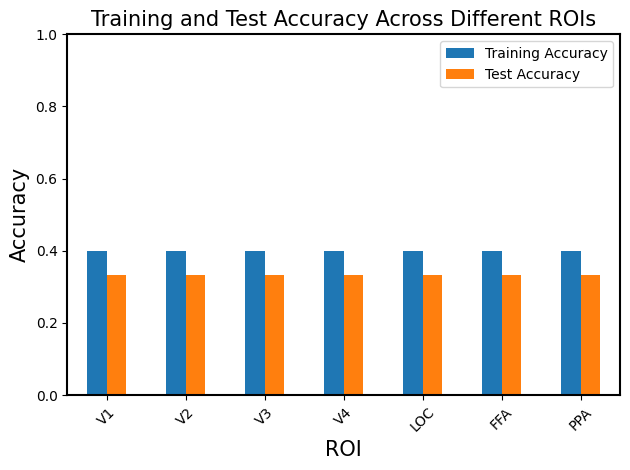

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
accuracy = pd.DataFrame(index=roi_list, columns=['Training Accuracy', 'Test Accuracy'])# Initialize a DataFrame to store accuracy results for each ROI
results_table = pd.DataFrame(index=roi_list, columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Mean Accuracy'])

for roi in roi_list:
    print(f"Processing ROI: {roi}")
    try:
        X, y = extract_data(roi, image_type='similar')
        # print(f"Data shape for ROI {roi}: {X.shape}, {y.shape}")

        # Flatten y if necessary
        if y.ndim > 1:
            y = y.flatten()

        # Initialize the model
        model = LogisticRegression(penalty='l2', max_iter=1000)

        # Perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation

        # Fill the table with the cross-validation results
        results_table.loc[roi, 'Fold 1':'Fold 5'] = scores
        results_table.loc[roi, 'Mean Accuracy'] = scores.mean()

        # Calculate and store the average accuracy
        # Calculate and store the average training accuracy
        average_accuracy = scores.mean()
        accuracy.loc[roi, 'Training Accuracy'] = average_accuracy

        # Train the model on the entire training set and evaluate on the test set
        model.fit(X_train, y_train)
        test_accuracy = model.score(X_test, y_test)
        accuracy.loc[roi, 'Test Accuracy'] = test_accuracy

        print(f"Cross-validation training accuracy for ROI {roi}: {average_accuracy:.2f}")
        print(f"Test accuracy for ROI {roi}: {test_accuracy:.2f}")

    except Exception as e:
        print(f"Error processing ROI {roi}: {e}")
# Print results table
print(results_table)
print(accuracy)

# Plot the accuracy
# accuracy.plot(kind='bar', legend=False)
# plt.title('Cross-Validation Accuracy Across Different ROIs')
# plt.xlabel('ROI')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# Plot the training and test accuracy
accuracy.plot(kind='bar', legend=True)
plt.title('Training and Test Accuracy Across Different ROIs')
plt.xlabel('ROI')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Logestic Regression (using 5-folds on training Data)
# Decoding accuracy across different ROIs and image types > To compare

roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
image_types = ['similar', 'different', 'imagery']
accuracy_cv = pd.DataFrame(index=roi_list, columns=image_types)
accuracy_test = pd.DataFrame(index=roi_list, columns=image_types)
model = LogisticRegression(penalty='l2')

for roi in roi_list:
    for image_type in image_types:
        X, y = extract_data(roi, image_type=image_type)
        y = y.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

        # Perform cross-validation on the training data
        scores = cross_val_score(model, X_train, y_train, cv=5)
        accuracy_cv.loc[roi, image_type] = scores.mean()

        # Refit the model on the entire training set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_test.loc[roi, image_type] = accuracy_score(y_test, y_pred)

print("Cross-Validation Accuracy:")
print(accuracy_cv)
print("\nTest Set Accuracy:")
print(accuracy_test)

# Plotting Training (cross-validation) Accuracy
accuracy_cv.plot(kind='bar', figsize=(10, 6), color=['aqua', 'hotpink', 'black'])
plt.title('Decoding Accuracy Across Different ROIs and Image Types (Training Set)')
plt.xlabel('ROI')
plt.ylabel('Cross-Validation Accuracy')
plt.legend(title='Image Type')
plt.show()

# Plotting Test Accuracy
accuracy_test.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'pink', 'gray'])
plt.title('Decoding Accuracy Across Different ROIs and Image Types (Test Set)')
plt.xlabel('ROI')
plt.ylabel('Test Set Accuracy')
plt.legend(title='Image Type')
plt.show()

#### Think
- What does the difference in decoding accuracy tell you about the encoding of stimuli in the brain?
- Why is the decoding accuracy profile different when the images within the same category are different?
- What kind of experiments or models can you think of using decoding techniques?

## Motor decoding dataset

Can decode hand shapes from this dataset?
http://brainliner.jp/data/brainliner/Hand_shape_decoding_Rock_Papers


# References

- Neuromatch Academy Computational Neuroscience Course
- Kamitani, Yukiyasu, and Frank Tong. "Decoding the visual and subjective contents of the human brain." Nature neuroscience 8.5 (2005): 679-685.
- Horikawa, Tomoyasu, and Yukiyasu Kamitani. "Generic decoding of seen and imagined objects using hierarchical visual features." Nature communications 8.1 (2017): 1-15.
- Shen, Guohua, et al. "Deep image reconstruction from human brain activity." PLoS computational biology 15.1 (2019): e1006633.